# Competition in an oligopolistic market 
## - The Cournot Model

Imports and set magics:

In [39]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#from modelproject import CournotModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Description**

Cournot competition descibes an industry wherein competing firms, who offers identical products. The firms complete via the quantity of output they individually produce, simultaneously and autonomously. This model is named after its founder, the French mathematician Augustin Cournot.

Firstly, we will take a look at the case of a duoploy where only two firms are competing the a given market. the model are given as followed:

$$
\begin{aligned}
\Pi_1(Q) & =p(Q)q_1-q_1MC_1 \\
\Pi_2(Q) & =p(Q)q_2-q_1MC_2 \\
\end{aligned}
$$

In the profit functions provided earlier, price is determined by the total output denoted as $Q$, where for two firms, the total output $Q$ equals the sum of their individual outputs $q_1$ and $q_2$. As an illustrative example, let's assume that the price (expressed as the inverse demand function) follows a linear format, represented by $p = a + bQ$. Consequently, the inverse demand function can be expressed as $p = a + q_1b + q_2b$.

## Analytical solution

In [40]:
#model = CournotModelClass()


#sol = model.sympy_solve()
#print("Symbolic solution for q1:", sol)

**Setting up with SymPy**

In [41]:
a = sm.symbols('a')
b = sm.symbols('b')
pi_1 = sm.symbols('pi_1')
pi_2 = sm.symbols('pi_2')
mc = sm.symbols('MC')
q1 = sm.symbols('q_1')
q2 = sm.symbols('q_2')
q_star = sm.symbols('q^*')

**Profit functions for each firm**

In [42]:
profit_1 = sm.Eq(pi_1,(a-b*q1-b*q2-mc)*q1)
profit_1

Eq(pi_1, q_1*(-MC + a - b*q_1 - b*q_2))

In [43]:
profit_2 = sm.Eq(pi_2,(a-b*q1-b*q2-mc)*q2)
profit_2

Eq(pi_2, q_2*(-MC + a - b*q_1 - b*q_2))

**FOC for each firm**

In [44]:
#FOC firm 1
profit_1 = (a-b*q1-b*q2-mc)*q1
foc_q1 = sm.diff(profit_1, q1)
foc_q1

-MC + a - 2*b*q_1 - b*q_2

In [45]:
#FOC firm 2
profit_2 = (a-b*q1-b*q2-mc)*q2
foc_q2 = sm.diff(profit_2, q2)
foc_q2

-MC + a - b*q_1 - 2*b*q_2

**Solving for q1 and q2**

In [46]:
#We solve FOC1 for q1
solve_q1 = sm.solve(foc_q1,q1)
solve_q1[0]

(-MC + a - b*q_2)/(2*b)

In [47]:
#We solve FOC2 for q2
solve_q2 = sm.solve(foc_q2,q2)
solve_q2[0]

(-MC + a - b*q_1)/(2*b)

In [48]:
solve_q1_subs = solve_q1[0].subs(q2,q_star)
solve_q1_subs

(-MC + a - b*q^*)/(2*b)

In [49]:
solve_q2_subs = solve_q2[0].subs(q1,q_star)
solve_q2_subs

(-MC + a - b*q^*)/(2*b)

In [50]:
nash_eq = sm.Eq(q_star,solve_q1_subs)
nash_eq

Eq(q^*, (-MC + a - b*q^*)/(2*b))

In [51]:
nash_eq_solve = sm.solve(nash_eq,q_star)
nash_eq_solve[0]

(-MC + a)/(3*b)

**Creating functions using Lamdify**

In [52]:
best_resp_q1 = sm.lambdify(args=(a,b,mc),expr=solve_q1[0])
best_resp_q2 = sm.lambdify(args=(a,b,mc),expr=solve_q2[0])
nash_qstar = sm.lambdify(args=(a,b,mc),expr=nash_eq_solve[0])

In [53]:
a_val = 50
b_val = 3
mc_vec = np.array([1,2,3,4,5])

nash_mc = nash_qstar(a_val, b_val, mc_vec)

for n in nash_mc:
    print(f'q*: {n:1.3f}')


q*: 5.444
q*: 5.333
q*: 5.222
q*: 5.111
q*: 5.000


If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

In [54]:

def profit_1_num(a,b,q1,q2,mc):
        return (a-b*q1-b*q2-mc)*q1

def BR1(q2,a,b,mc):
       sol_BR1 = optimize.minimize(lambda q: -profit_1_num(a,b,q,q2,mc),x0=0.1,bounds=[(0, None)])
       return sol_BR1.x[0]
       
def profit_2_num(a,b,q1,q2,mc):
        return (a-b*q1-b*q2-mc)*q2

def BR2(q1,a,b,mc):
       sol_BR2 = optimize.minimize(lambda q: -profit_2_num(a,b,q1,q,mc),x0=0.1,bounds=[(0, None)])
       return sol_BR2.x[0]

def H(q, a, b, mc):
    q1,q2 = q
    err1 = BR1(q2,a,b,mc)-q1
    err2 = BR2(q1,a,b,mc)-q2
    return [err1, err2]

a = 50
b = 3
mc = 2

# Solve for Nash equilibrium
result = optimize.root(lambda q: H(q, a, b, mc), [0.1, 0.1])

# Extract equilibrium quantities
q_star = result.x
q1_star, q2_star = q_star

print("Nash Equilibrium:")
print("q1* =", q1_star)
print("q2* =", q2_star)


Nash Equilibrium:
q1* = 5.333333132964187
q2* = 5.333333428406956


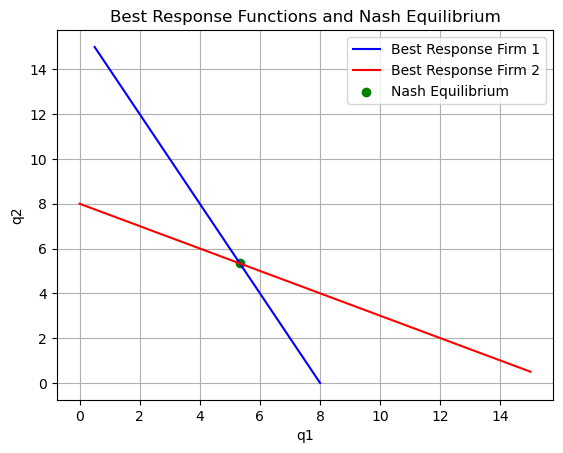

In [55]:
# Define the range of q1 and q2 values
q_values = np.linspace(0, 15, 100)  # Adjust the range for q_values

# Calculate corresponding q1 values using the best response function for firm 1
q1_values = [BR1(q2, a, b, mc) for q2 in q_values]

# Calculate corresponding q2 values using the best response function for firm 2
q2_values = [BR2(q1, a, b, mc) for q1 in q_values]

# Plot the best response functions for both firms
plt.plot(q1_values, q_values, label='Best Response Firm 1', color='blue')
plt.plot(q_values, q2_values, label='Best Response Firm 2', color='red')

# Plot the Nash Equilibrium point
plt.scatter(q1_star, q2_star, color='green', label='Nash Equilibrium')

plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Best Response Functions and Nash Equilibrium')
plt.legend()
plt.grid(True)

plt.show()


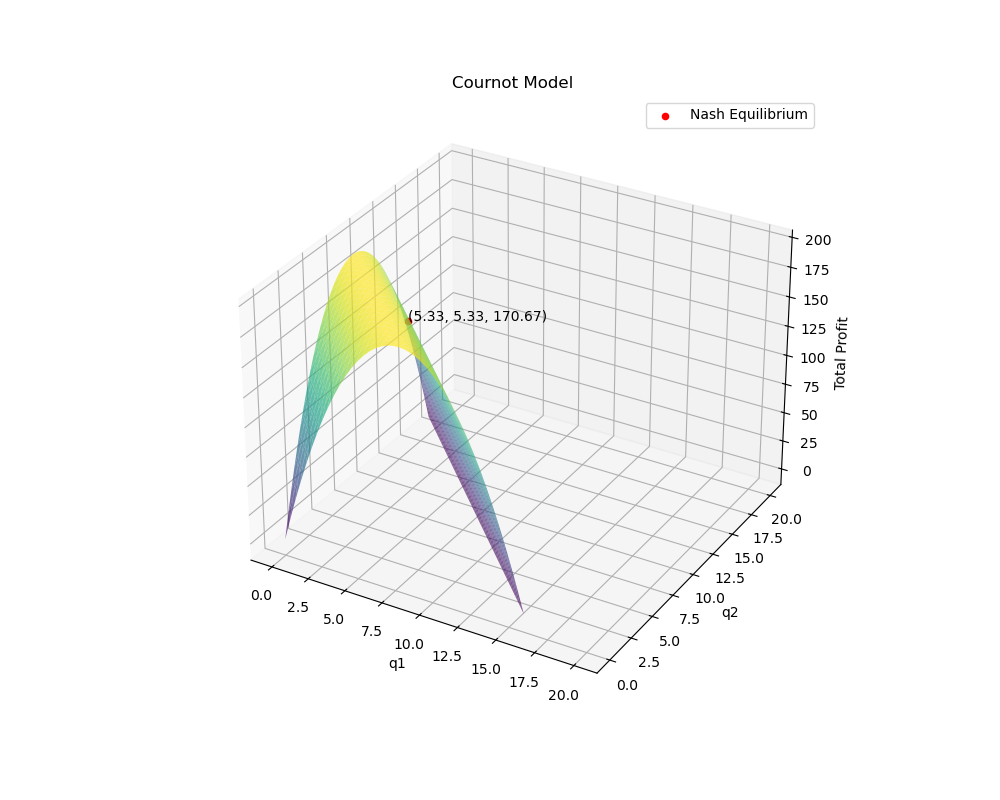

In [56]:
%matplotlib widget

def total_profit(q, a, b, mc):
    q1, q2 = q
    return profit_1_num(a, b, q1, q2, mc) + profit_2_num(a, b, q1, q2, mc)

profit_star = total_profit(q_star, a, b, mc)

q1_range = np.linspace(0, 20, 100)
q2_range = np.linspace(0, 20, 100)
q1, q2 = np.meshgrid(q1_range, q2_range)
profit = total_profit([q1, q2], a, b, mc)

profit[profit < 0] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q1, q2, profit, cmap='viridis', alpha=0.7)
ax.scatter(q1_star, q2_star, profit_star, color='red', label='Nash Equilibrium')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('Total Profit')
ax.set_title('Cournot Model')

# Annotate Nash equilibrium point
ax.text(q1_star, q2_star, profit_star, f'({q1_star:.2f}, {q2_star:.2f}, {profit_star:.2f})', color='black')

ax.legend()
plt.show()

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

In [57]:
# Define profit functions and best response functions for Firm 1
def profit_1_num(a, b, q1, q2, q3, mc):
    return (a - b*q1 - b*q2 - b*q3 - mc) * q1

def BR1(q2, q3, a, b, mc):
    sol_BR1 = optimize.minimize(lambda q: -profit_1_num(a, b, q, q2, q3, mc), x0=0.1, bounds=[(0, None)])
    return sol_BR1.x[0]  

# Define profit functions and best response functions for Firm 2
def profit_2_num(a, b, q1, q2, q3, mc):
    return (a - b*q1 - b*q2 - b*q3 - mc) * q2

def BR2(q1, q3, a, b, mc):
    sol_BR2 = optimize.minimize(lambda q: -profit_2_num(a, b, q1, q, q3, mc), x0=0.1, bounds=[(0, None)])
    return sol_BR2.x[0]

# Define profit functions and best response functions for Firm 3
def profit_3_num(a, b, q1, q2, q3, mc):
    return (a - b*q1 - b*q2 - b*q3 - mc) * q3

def BR3(q1, q2, a, b, mc):
    sol_BR3 = optimize.minimize(lambda q: -profit_3_num(a, b, q1, q2, q, mc), x0=0.1, bounds=[(0, None)])
    return sol_BR3.x[0]

# Define function H(q)
def H(q, a, b, mc):
    q1, q2, q3 = q
    err1 = BR1(q2, q3, a, b, mc) - q1
    err2 = BR2(q1, q3, a, b, mc) - q2
    err3 = BR3(q1, q2, a, b, mc) - q3
    return [err1, err2, err3]

# Set parameters
a = 50
b = 3
mc = 1

# Solve for Nash equilibrium
result = optimize.root(lambda q: H(q, a, b, mc), [0.1, 0.1, 0.1])

# Extract equilibrium quantities
q_star = result.x
q1_star, q2_star, q3_star = q_star

print("Nash Equilibrium:")
print("q1* =", q1_star)
print("q2* =", q2_star)
print("q3* =", q3_star)

Nash Equilibrium:
q1* = 4.083333358357541
q2* = 4.0833330289272185
q3* = 4.083333475753608


Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

**The model**

$$
\begin{aligned}
\pi_i(q_1,....,q_n) & =q_iP \left( \sum_{j=1}^{n}q_j\right)-C_i(q_i) \\

\end{aligned}
$$
  

# Conclusion

Add concise conclusion. 